In [1]:
# ✅ Install dependencies
%pip install ultralytics opencv-python albumentations
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os
import cv2
import glob
import random
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from ultralytics import YOLO

print("✅ GPU available:", torch.cuda.is_available())
print("🖥️  Current GPU device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# ✅ Dataset root
DATA_DIR = "E:/Work/KSA/Model1/DatasetV1"
AUG_SPLIT = "train_aug"

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
✅ GPU available: True
🖥️  Current GPU device: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
# ✅ Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.7),
    A.Blur(p=0.2),
    A.GaussNoise(p=0.2),
    A.HueSaturationValue(p=0.3),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# ✅ Create folders for augmented data
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/images", exist_ok=True)
os.makedirs(f"{DATA_DIR}/{AUG_SPLIT}/labels", exist_ok=True)

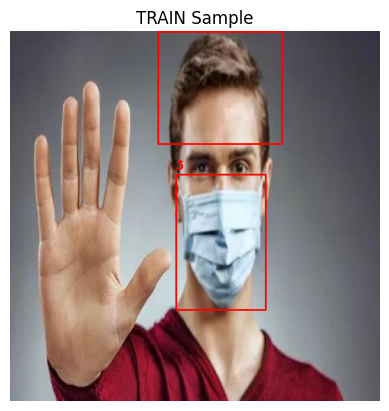

In [3]:
# ✅ Function to show a random sample with bounding boxes
def show_random_sample(split="train"):
    img_path = random.choice(glob.glob(f"{DATA_DIR}/{split}/images/*.jpg"))
    label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                cls, x_center, y_center, w, h = map(float, line.strip().split())
                h_img, w_img = img.shape[:2]
                x_center *= w_img
                y_center *= h_img
                w *= w_img
                h *= h_img
                x1 = int(x_center - w / 2)
                y1 = int(y_center - h / 2)
                x2 = int(x_center + w / 2)
                y2 = int(y_center + h / 2)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{split.upper()} Sample")
    plt.show()

# ✅ Display a random sample
show_random_sample("train")

# Class 0: No Mask
# Class 1: No Hairnet
# Class 2: Hairnet
# Class 3: Mask

In [4]:
# ✅ Data augmentation function
def augment_and_save(img_path, label_path, out_split="train_aug", max_augs=3):
    img = cv2.imread(img_path)
    h_img, w_img = img.shape[:2]

    with open(label_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    class_labels = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        bboxes.append([x, y, w, h])
        class_labels.append(int(cls))

    base_name = os.path.basename(img_path).replace(".jpg", "")

    for i in range(max_augs):
        aug_img_name = f"{base_name}_aug{i}.jpg"
        aug_img_path = os.path.join(DATA_DIR, out_split, "images", aug_img_name)
        aug_label_path = os.path.join(DATA_DIR, out_split, "labels", aug_img_name.replace(".jpg", ".txt"))

        if os.path.exists(aug_img_path):
            continue

        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_labels = transformed['class_labels']

        cv2.imwrite(aug_img_path, aug_img)
        with open(aug_label_path, 'w') as f:
            for cls_id, bbox in zip(aug_labels, aug_bboxes):
                f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

In [5]:
# ✅ Run augmentation
for split in ["train"]:
    img_paths = glob.glob(f"{DATA_DIR}/{split}/images/*.jpg")
    for img_path in img_paths:
        if "_aug" in os.path.basename(img_path):
            continue
        label_path = img_path.replace("images", "labels").replace(".jpg", ".txt")
        if os.path.exists(label_path):
            augment_and_save(img_path, label_path, out_split=AUG_SPLIT)

print("✅ Augmentation complete.")

✅ Augmentation complete.


In [6]:
# ✅ Load and train YOLOv8m model
model = YOLO('yolov8m.pt')

model.train(
    data=f"{DATA_DIR}/data.yaml",
    epochs=50,
    imgsz=640,
    batch=8,
    name="mask_hairnet_v1",
    project="E:/Work/KSA/Model1",
    device=0,
    conf=0.001, 
    iou=0.45, 
    box=True,   
    cls=True,
    agnostic_nms=False, 
    optimizer="AdamW" 
)

New https://pypi.org/project/ultralytics/8.3.170 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=True, cache=False, cfg=None, classes=None, close_mosaic=10, cls=True, conf=0.001, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=E:/Work/KSA/Model1/DatasetV1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.45, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mask_hairnet_v1, 

train: Scanning E:\Work\KSA\Model1\DatasetV1\train\labels.cache... 107 images, 0 backgrounds, 0 corrupt: 100%|██████████| 107/107 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access  (ping: 0.10.0 ms, read: 343.856.1 MB/s, size: 45.9 KB)


val: Scanning E:\Work\KSA\Model1\DatasetV1\valid\labels.cache... 10 images, 1 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]


Plotting labels to E:\Work\KSA\Model1\mask_hairnet_v1\labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to E:\Work\KSA\Model1\mask_hairnet_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.38G     0.3124      20.78      2.218         14        640: 100%|██████████| 14/14 [00:02<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         10         51      0.301       0.41     0.0723     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.54G     0.3946      19.65       2.45         51        640: 100%|██████████| 14/14 [00:01<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.84it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.54G     0.4408      8.602      2.686         43        640: 100%|██████████| 14/14 [00:01<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.24it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.54G      0.418      8.606      2.654         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.82it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.54G     0.4146      8.228      2.636         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.12it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.54G     0.4338      8.317      2.799         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 18.68it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.54G       0.43      8.091      2.694         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.54G     0.4383      8.493      2.783          8        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 19.28it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.54G     0.4172      8.065      2.643         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.54G     0.4179          8      2.624         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.01it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.54G     0.4078      8.232      2.702         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.77it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.54G     0.3926        8.1      2.621         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.00it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.54G     0.3982      7.769      2.645         40        640: 100%|██████████| 14/14 [00:01<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.49it/s]

                   all         10         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.54G     0.4037      7.738      2.652         26        640: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.13it/s]

                   all         10         51    0.00259     0.0855    0.00156   0.000448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.54G     0.3931      7.863      2.625         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.99it/s]

                   all         10         51    0.00275     0.0662    0.00159   0.000635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.54G     0.3897      7.658      2.687         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]

                   all         10         51    0.00473      0.105    0.00305   0.000889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.54G     0.3969      7.656      2.641         11        640: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.67it/s]

                   all         10         51     0.0179     0.0994     0.0354     0.0107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.54G     0.3811      7.234      2.565         34        640: 100%|██████████| 14/14 [00:01<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.93it/s]

                   all         10         51      0.598     0.0833     0.0805     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.54G     0.3855      7.711      2.603          3        640: 100%|██████████| 14/14 [00:01<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.99it/s]

                   all         10         51      0.337     0.0972     0.0819      0.024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.54G     0.3827      7.166      2.554         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]

                   all         10         51      0.019      0.235     0.0751     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.54G     0.3731      7.036       2.58         45        640: 100%|██████████| 14/14 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.12it/s]

                   all         10         51      0.514     0.0748      0.121     0.0439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.54G     0.3741      7.149      2.621         24        640: 100%|██████████| 14/14 [00:01<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]

                   all         10         51      0.449     0.0734     0.0845     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.54G     0.3727      6.743      2.566         17        640: 100%|██████████| 14/14 [00:01<00:00,  8.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.13it/s]

                   all         10         51      0.399     0.0556     0.0945     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.54G      0.372      6.843      2.571         42        640: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all         10         51      0.391      0.147      0.131     0.0433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.54G     0.3767      6.744      2.526          6        640: 100%|██████████| 14/14 [00:01<00:00,  8.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.71it/s]

                   all         10         51      0.702      0.151      0.146     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.54G     0.3665        6.8      2.575         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.21it/s]

                   all         10         51      0.427      0.105      0.106     0.0428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.54G     0.3723      6.945      2.656         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.27it/s]

                   all         10         51      0.442      0.147      0.141     0.0579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.54G     0.3672      6.773      2.607         36        640: 100%|██████████| 14/14 [00:01<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.62it/s]

                   all         10         51      0.399      0.175      0.163     0.0674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.54G     0.3701      6.626       2.55         28        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.72it/s]

                   all         10         51      0.635      0.115      0.143     0.0541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.54G     0.3559      6.547      2.531         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

                   all         10         51       0.57      0.153      0.114     0.0592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.54G     0.3627      6.667      2.512         32        640: 100%|██████████| 14/14 [00:01<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.80it/s]

                   all         10         51      0.994     0.0833      0.123     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.54G     0.3598      6.931      2.659         15        640: 100%|██████████| 14/14 [00:01<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.34it/s]

                   all         10         51      0.714      0.125      0.197     0.0902



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.54G     0.3654      6.609      2.504         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.92it/s]

                   all         10         51      0.736      0.153      0.276      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.54G     0.3551      6.337      2.584         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.06it/s]

                   all         10         51      0.979      0.149      0.225      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.54G     0.3394      6.204      2.522         13        640: 100%|██████████| 14/14 [00:01<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.65it/s]

                   all         10         51       0.97      0.139      0.229      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.54G     0.3571       6.08      2.544         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.05it/s]

                   all         10         51       0.46      0.185      0.213      0.085



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.54G     0.3618      6.128      2.452         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.53it/s]

                   all         10         51      0.584      0.195      0.178     0.0749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.54G     0.3527      6.312      2.495         18        640: 100%|██████████| 14/14 [00:01<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.02it/s]

                   all         10         51      0.177      0.176      0.196     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.54G     0.3636      5.986      2.434         23        640: 100%|██████████| 14/14 [00:01<00:00,  8.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.47it/s]

                   all         10         51       0.16      0.176       0.22     0.0954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.54G     0.3486       5.85      2.354         25        640: 100%|██████████| 14/14 [00:01<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.09it/s]

                   all         10         51      0.153      0.223      0.227     0.0993


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.54G     0.3529      6.481      2.549          6        640: 100%|██████████| 14/14 [00:02<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.73it/s]

                   all         10         51      0.523      0.226      0.255      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.54G     0.3439      6.221      2.503         37        640: 100%|██████████| 14/14 [00:01<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.94it/s]

                   all         10         51      0.513      0.212      0.292      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.54G     0.3321       6.22      2.541         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.21it/s]

                   all         10         51      0.567      0.249      0.311       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.54G     0.3361      6.017      2.503         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.88it/s]

                   all         10         51      0.604       0.24      0.333     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.54G     0.3314      5.994      2.536         15        640: 100%|██████████| 14/14 [00:01<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.26it/s]

                   all         10         51      0.494      0.249      0.333     0.0918



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.54G      0.343      5.908      2.566         19        640: 100%|██████████| 14/14 [00:01<00:00,  8.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.01it/s]

                   all         10         51      0.441      0.249      0.331      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.54G      0.338      5.836      2.508         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.22it/s]

                   all         10         51      0.449      0.305      0.317      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.54G     0.3382      5.832      2.545         12        640: 100%|██████████| 14/14 [00:01<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

                   all         10         51      0.382      0.314      0.326      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.54G     0.3322      5.563      2.433         14        640: 100%|██████████| 14/14 [00:01<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]

                   all         10         51      0.319       0.29      0.324      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.54G     0.3425      5.629      2.463         22        640: 100%|██████████| 14/14 [00:01<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.58it/s]

                   all         10         51      0.274      0.274      0.321      0.124



50 epochs completed in 0.038 hours.
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\last.pt, 52.0MB
Optimizer stripped from E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt, 52.0MB

Validating E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt...
Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4080 Laptop GPU, 12282MiB)
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.33it/s]


                   all         10         51      0.274      0.274       0.32      0.124
               NO mask          5          6      0.307       0.23       0.24     0.0806
             NOhairnet          2         13          0          0      0.139     0.0495
               hairnet          8         14      0.195      0.143      0.171     0.0373
                  mask          4         18      0.596      0.722      0.732       0.33
Speed: 0.1ms preprocess, 3.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000142E6DA9FC0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

In [7]:
# ✅ Export to ONNX
trained_model = YOLO("E:/Work/KSA/Model1/mask_hairnet_v1/weights/best.pt")
trained_model.export(format="onnx", dynamic=False, simplify=True, opset=12)
print("✅ Model exported to ONNX.")

Ultralytics 8.3.169  Python-3.10.18 torch-2.5.1+cu121 CPU (13th Gen Intel Core(TM) i9-13900HX)
 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 92 layers, 25,842,076 parameters, 0 gradients, 78.7 GFLOPs

PyTorch: starting from 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 8, 8400) (49.6 MB)

ONNX: starting export with onnx 1.17.0 opset 12...
ONNX: slimming with onnxslim 0.1.61...
ONNX: export success  2.6s, saved as 'E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx' (98.7 MB)

Export complete (3.4s)
Results saved to E:\Work\KSA\Model1\mask_hairnet_v1\weights
Predict:         yolo predict task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640  
Validate:        yolo val task=detect model=E:\Work\KSA\Model1\mask_hairnet_v1\weights\best.onnx imgsz=640 data=E:/Work/KSA/Model1/Da